How many cascaded circuits:12

Equivalent resistance initially: 
2.400000000000024

Initial Currents: 
[[3.75000000e+00]
 [0.00000000e+00]
 [2.72727273e+00]
 [0.00000000e+00]
 [7.43801653e-01]
 [0.00000000e+00]
 [2.02854996e-01]
 [0.00000000e+00]
 [5.53240899e-02]
 [0.00000000e+00]
 [1.50883882e-02]
 [0.00000000e+00]
 [4.11501514e-03]
 [0.00000000e+00]
 [1.12227750e-03]
 [0.00000000e+00]
 [3.06078047e-04]
 [0.00000000e+00]
 [8.34845024e-05]
 [0.00000000e+00]
 [2.28002958e-05]
 [0.00000000e+00]
 [6.33484480e-06]
 [0.00000000e+00]
 [2.15515339e-06]]

Initial Currents and Odd Numbered Current Derivatives (last terms): 
[ 3.75000000e+00  7.36372414e-16  2.72727273e+00 -0.00000000e+00
  7.43801653e-01  7.04564612e-17  2.02854996e-01 -1.40912922e-17
  5.53240899e-02  2.64211729e-18  1.50883882e-02  0.00000000e+00
  4.11501514e-03  6.60529324e-19  1.12227750e-03 -1.10088221e-19
  3.06078047e-04  6.88051379e-21  8.34845024e-05  0.00000000e+00
  2.28002958e-05  0.00000000e+00  6.33484480e-06  0

<ipython-input-6-15f2af33833b>:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure() #comment this line out to see all currents on same graph


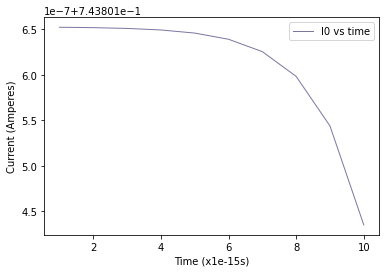

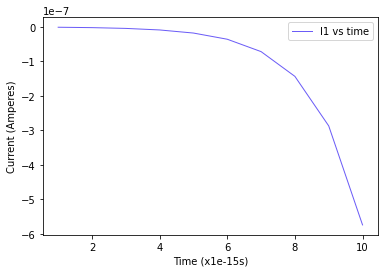

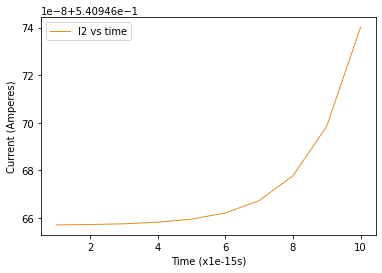

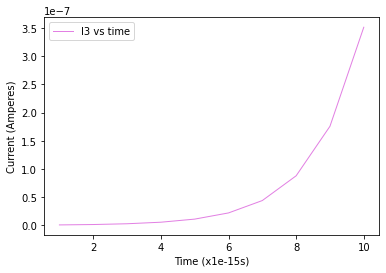

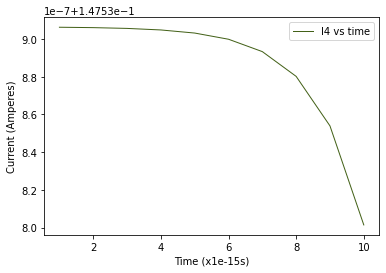

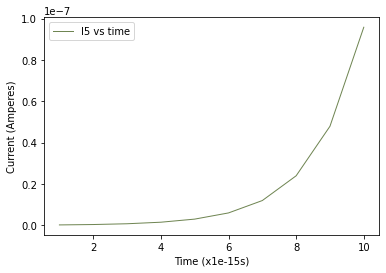

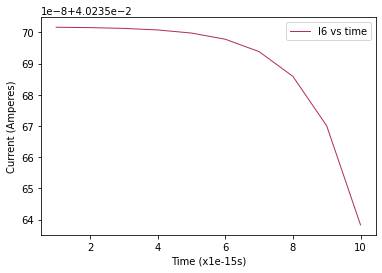

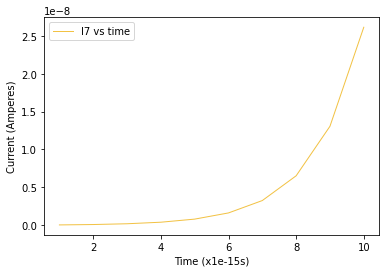

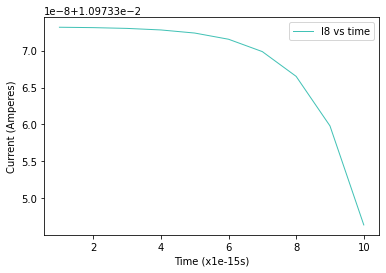

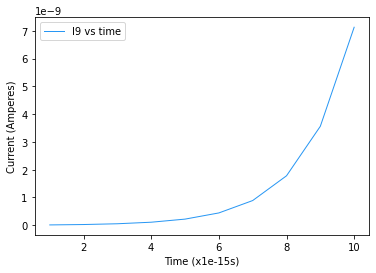

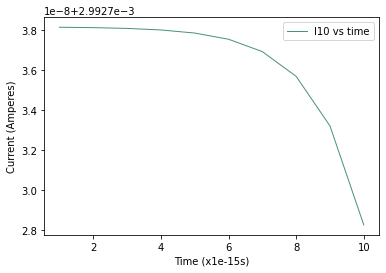

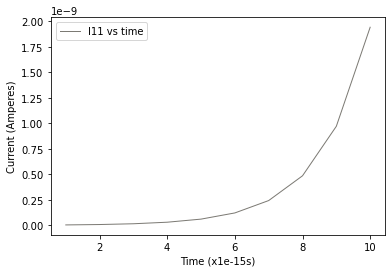

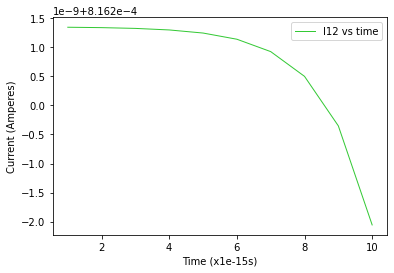

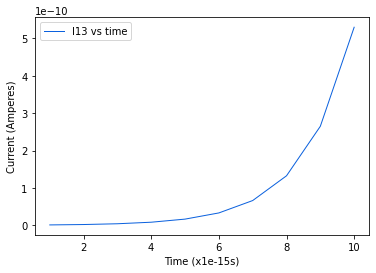

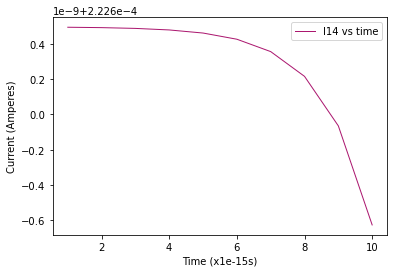

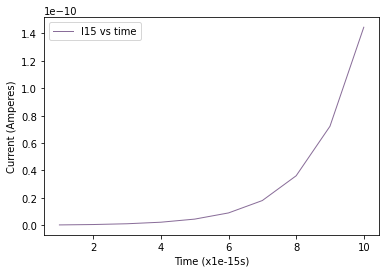

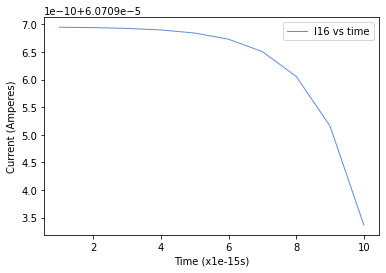

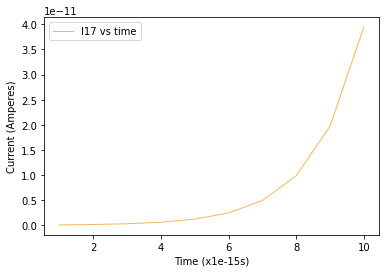

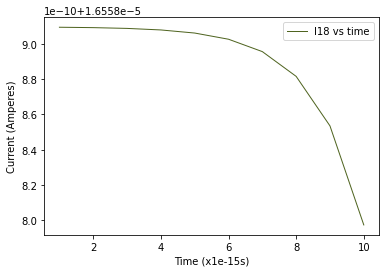

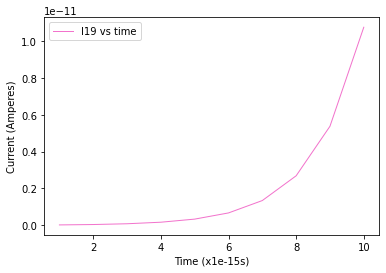

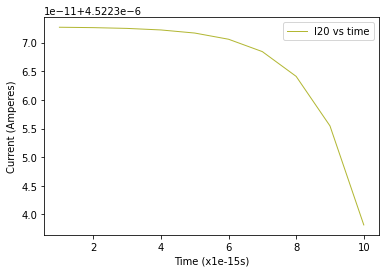

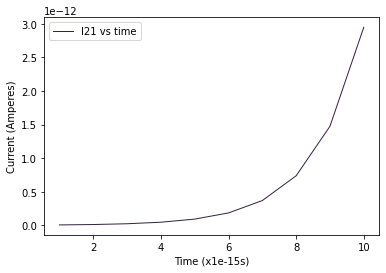

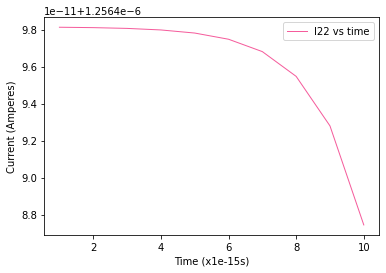

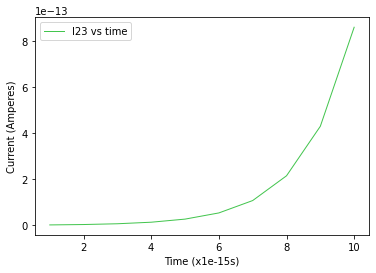

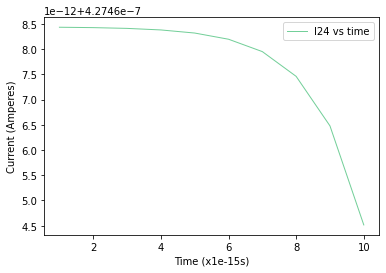

In [6]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt


circuitnum = int(input("How many cascaded circuits:"))
#timeeval = float(input("What time to evaluate at: "))

I_0 = np.zeros([2*circuitnum+1, 1], dtype = 'double') #array to hold the various currents' initial values
R_0 = np.zeros([2*circuitnum+1, 1], dtype = 'double') # 'weights' defined during R0_eq calculations to detemine initial current split
sys = np.zeros([circuitnum+1, circuitnum+1], dtype = 'double') #will hold linear equations determining current split
sys2 = np.zeros([3*circuitnum+1, 3*circuitnum+1], dtype='double') #columns: I0, I1, I2, I3, I4, I5, I6, I'1, I'3, I'5
solcol = np.zeros([circuitnum+1, 1], dtype = 'double') #used as solution matrix for sys
soln2 = np.zeros([3*circuitnum+1], dtype = 'double')#solution matrix for sys2

#capacitor (Farad), resistor(Ohm), inductor(Henry), and EMF (Volts) values
Ro = 1.0
Rm = 3.3
Ri = 2.2
L = 1e-5
C1 = 1e-5
C2 = 1e-6
EMF = 9.0

#forward euler timestepped to determine next function value using current funcition value, derivative
def timestepfunc(f0, derf, dt ):
    f = f0 + derf*dt
    return f

#assumes inductors = circuit break and capacitor = wire at t = 0 to find equivalent resistance of circuit
def R0_eq ():
    R_eq = Rm
    for n in range(circuitnum):
        R_eq += 2*(Ri+Ro)
        R_0[2*(circuitnum - n)] = R_eq #only need circuitnum-1 terms, last term generated is a throwaway
        R_eq = 1/((1/R_eq)+1/Rm)
    return R_eq

#finds initial current output by EMF at t = 0
def I0():
    I_max = EMF/R0_eq()
    return I_max



#assigns coefficients to sys and solves systems, pattern was analytically determined
#returns matrix: I0, I1, I2, I3, I4, I5, I6, I'1, I'3, I'5
def solveI0():
    print("\nEquivalent resistance initially: ")
    print(R0_eq())
    solcol[circuitnum] = I0()
    for i in range(circuitnum):
        sys[circuitnum - 1 - i][i] = -1
        for j in range(i):
            sys[i-1][j-i] = (R_0[2*(circuitnum - i+1)])/Rm
    for x in range(circuitnum+1):
        sys[circuitnum-1][x] = -1.0
        sys[circuitnum-1][0] = 1.0
    sys[circuitnum][0] = 1.0    
    
    solution = np.linalg.solve(sys, solcol)    
    
    for n in range(circuitnum+1):
        I_0[2*n-1] = 0.0
        I_0[2*n] = solution[n]

    print("\nInitial Currents: ")
    print(I_0)  
    
    for x in range(circuitnum*2+1):
        sys2[circuitnum+x][x] = 1.0
                    
    for n in range(circuitnum):
        sys2[n][(1+n+2*circuitnum)] = L   
        
    for i in range(1, circuitnum):
        for j in range(2*i):
            sys2[i][j] = -(Ri+Ro)
        sys2[i][0] = (Ro+Ri)
        sys2[i][2*i] = -(Rm+Ri+Ro)
        sys2[i][2*i+1] = Rm
        
    #weird I' so manually assigned
    sys2[0][0] = Rm+Ro+Ri
    sys2[0][1] = Rm
    soln2[0] = EMF
    for current in range(np.size(I_0)):
        soln2[circuitnum+current] = I_0[current]
   
    sol = np.linalg.solve(sys2, soln2)
    
    print('\nInitial Currents and Odd Numbered Current Derivatives (last terms): ' )
    print(sol)
    return sol

#iteratively timestep and solve algebraically
def iteratedsolve(sol, sys2, soln2, dt):
    updatesoln = np.zeros_like(soln2, dtype = 'double') #The "b" in Ax = b
    updatesys = np.zeros_like(sys2, dtype = 'double') # The "A" in Ax = b
   
    #initializing "A", the coefficient matrix in Ax = b
    for term in range(circuitnum):
        updatesys[2*term+circuitnum+1][2*term+1] = 1.0
        updatesys[circuitnum + 2*(term+1)][0] = Ri+Ro
        updatesys[circuitnum + 2*(term+1)][term + 1+ 2*circuitnum] = -L  
        updatesys[term][term + 1+ 2*circuitnum] = L   
        updatesys[circuitnum + 2*(term+1)][2*term+1] += -(Rm + dt/(2*C2))
        for i in range(2*term+1):
            updatesys[circuitnum + 2*(term+1)][i+1] += -(Ri+Ro)
        updatesys[circuitnum + 2*(term+1)][2*term+2] = Rm + dt/(2*C1)
    
    for deriv in range(circuitnum-1):
        updatesys[1+deriv][0] += (Ri+Ro)
        updatesys[1+deriv][2*(deriv+1)] = -(Rm +dt/(2*C1))
        updatesys[1+deriv][2*(deriv)+3] = (Rm +dt/(2*C2))
        for j in range(2*(deriv+1)):
            updatesys[1+deriv][1+j] += -(Ri+Ro) #circuit derivative eqns
   
    for x in range(circuitnum*2+1):
        updatesys[circuitnum][x] = -1.0
        updatesys[circuitnum][0] = 1.0
    
    #terms that don't follow pattern initialized by hand
    updatesys[0][0] = Ri+Ro+Rm + dt/(2*C1)
    updatesys[0][1] = dt/(2*C2) + Rm
    updatesoln[0] = EMF
    
    
    #timestepping 
    n=10
    x_coord = np.zeros([n]) #for graphing
    y_coord = np.zeros([3*n+1, n]) #for graphing #2
    for step in range(n):
        for term in range(circuitnum):
            updatesoln[2*term+circuitnum+1] += timestepfunc(sol[2*term+1],sol[term+circuitnum*2+1], dt)
            updatesoln[circuitnum + 2*(term+1)] += (dt/(2*C2))*(sol[2*term+1])-(dt/(2*C1))*sol[2*(term+1)]   
       
        for deriv in range(circuitnum-1):
            updatesoln[1+deriv] += sol[2*(deriv+1)]*dt/(2*C1)
            updatesoln[1+deriv] += -sol[2*(deriv+1)+1]*dt/(2*C2)               
       
        updatesoln[0] += -sol[0]*dt/(2*C1)
        updatesoln[0] += -sol[1]*dt/(2*C2)
        A_inv = np.linalg.inv(updatesys)
        det = np.linalg.det(updatesys)
        sol = np.linalg.solve(updatesys, updatesoln)#The "x" in Ax = b         
        print('\nSolution at Timestep: %d' % (step+1))
        print(sol)
        
        x_coord[step] = step+1
        for current in range(2*circuitnum+1):
            y_coord[current][step] = sol[current]   
             
    #graphing
    for current in range(2*circuitnum+1):
        rgb = np.ndarray.tolist(np.random.rand(3,))
        fig = plt.figure() #comment this line out to see all currents on same graph
        plt.plot(x_coord, y_coord[current], c=rgb, label="I%s vs time" % str(current), linestyle="-", linewidth=1)     
        plt.xlabel("Time (x1e-15s)")
        plt.ylabel("Current (Amperes)") 
        plt.legend()
    

iteratedsolve(solveI0(), sys2, soln2, 1e-15)

## 

### 